# thread
Q so in real case
does different threads decides differnet users or one user can have many threads
### answer
### Threads are not automatically tied to users — you decide how to assign them.

You could make 1 thread per user, or multiple threads per user for different workflows.

Checkpoint

In [1]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import InMemorySaver
from typing import Annotated
from typing_extensions import TypedDict
from operator import add

class State(TypedDict):
    foo: str
    bar: Annotated[list[str], add]

def node_a(state: State):
    return {"foo": "a", "bar": ["a"]}

def node_b(state: State):
    return {"foo": "b", "bar": ["b"]}


workflow = StateGraph(State)
workflow.add_node(node_a)
workflow.add_node(node_b)
workflow.add_edge(START, "node_a")
workflow.add_edge("node_a", "node_b")
workflow.add_edge("node_b", END)

checkpointer = InMemorySaver()
graph = workflow.compile(checkpointer=checkpointer)

config = {"configurable": {"thread_id": "1"}}
graph.invoke({"foo": ""}, config)

{'foo': 'b', 'bar': ['a', 'b']}

In [ ]:
# get the latest state snapshot
config = {"configurable": {"thread_id": "1"}}
print(graph.get_state(config))

StateSnapshot(values={'foo': 'b', 'bar': ['a', 'b']}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f074956-b9fe-6098-8002-86390c70468e'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}, 'thread_id': '1'}, created_at='2025-08-08T20:22:35.307432+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f074956-b9fe-6097-8001-17e831a62e6f'}}, tasks=(), interrupts=())


In [3]:

# get a state snapshot for a specific checkpoint_id
config = {"configurable": {"thread_id": "1", "checkpoint_id": "1ef663ba-28fe-6528-8002-5a559208592c"}}
graph.get_state(config)

StateSnapshot(values={}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_id': '1ef663ba-28fe-6528-8002-5a559208592c'}}, metadata=None, created_at=None, parent_config=None, tasks=(), interrupts=())

In [5]:
config = {"configurable": {"thread_id": "1"}}
list(graph.get_state_history(config))

[StateSnapshot(values={'foo': 'b', 'bar': ['a', 'b']}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f074956-b9fe-6098-8002-86390c70468e'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}, 'thread_id': '1'}, created_at='2025-08-08T20:22:35.307432+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f074956-b9fe-6097-8001-17e831a62e6f'}}, tasks=(), interrupts=()),
 StateSnapshot(values={'foo': 'a', 'bar': ['a']}, next=('node_b',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f074956-b9fe-6097-8001-17e831a62e6f'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}, 'thread_id': '1'}, created_at='2025-08-08T20:22:35.307432+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f074956-b9f9-68f6-8000-74d73c733099'}}, tasks=(PregelTask(id='226148c8-ddef-4bd9-995a-64eea0a0e9ca', name='node_b', path=('__pregel_pull

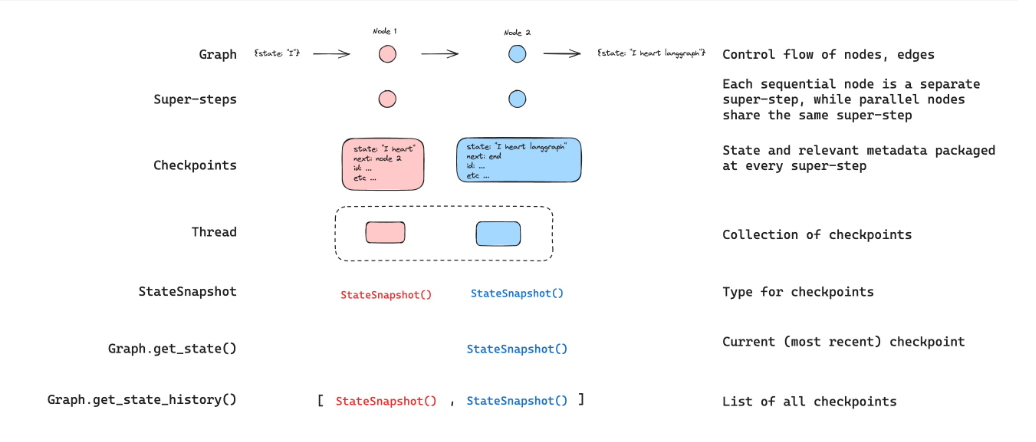

## Replay
It's also possible to play-back a prior graph execution. If we invoke a graph with a thread_id and a checkpoint_id, then we will re-play the previously executed steps before a checkpoint that corresponds to the checkpoint_id, and only execute the steps after the checkpoint.

In [7]:
config = {"configurable": {"thread_id": "1", "checkpoint_id": "1f074956-b9f9-68f6-8000-74d73c733099"}}
graph.invoke(None, config=config)   

{'foo': 'b', 'bar': ['a', 'b']}

In [8]:
config = {"configurable": {"thread_id": "1"}}
list(graph.get_state_history(config))

[StateSnapshot(values={'foo': 'b', 'bar': ['a', 'b']}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f074971-6b50-6093-8002-6ac8fd4fdc1e'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}, 'thread_id': '1'}, created_at='2025-08-08T20:34:31.833000+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f074971-6b48-6b56-8001-4bd28ebbc8ae'}}, tasks=(), interrupts=()),
 StateSnapshot(values={'foo': 'a', 'bar': ['a']}, next=('node_b',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f074971-6b48-6b56-8001-4bd28ebbc8ae'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}, 'thread_id': '1'}, created_at='2025-08-08T20:34:31.829999+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f074956-b9f9-68f6-8000-74d73c733099'}}, tasks=(PregelTask(id='e139e06c-6839-6eb5-e50c-7d33a488dab0', name='node_b', path=('__pregel_pull